In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.data import HeteroData

from grad_june.transmission import TransmissionSampler
from grad_june.infection_networks import HouseholdNetwork, SchoolNetwork, InfectionNetworks
from grad_june.symptoms import SymptomsSampler, SymptomsUpdater
from grad_june.policies import Policies
from grad_june.model import GradJune
from grad_june.infection_seed import InfectionSeedByFraction
from grad_june.timer import Timer
from grad_june.runner import Runner
from grad_june.paths import default_config_path

In [3]:
device = "cpu" # could be cuda:0 for gpu, etc.
june_config_path = default_config_path # change to custom config

# 1. Load world data

The first step is to create the network of contacts of the population.
Let's do a simple one to illustrate the process.

In [4]:
# We first initialize info about agents
n_agents = 100

data = HeteroData()
data["agent"].id = torch.arange(0, n_agents)
data["agent"].age = torch.randint(0, 100, (n_agents,))
data["agent"].sex = torch.randint(0, 2, (n_agents,))
data["agent"].area_id = torch.randint(0, 10, (n_agents,))


# Now we initialize some venues (1 household and 1 school)
data["household"].id = torch.zeros(1)
data["school"].id = torch.zeros(1)

# Now we assign people to them, in this case, half to the house and half to the school.
data["household"].people = torch.tensor([n_agents//2])
data["school"].people = torch.tensor([n_agents//2])
data["agent", "attends_household", "household"].edge_index = torch.vstack(
    (data["agent"].id[::2], torch.zeros(n_agents//2, dtype=torch.long))
)
data["agent", "attends_school", "school"].edge_index = torch.vstack(
    (data["agent"].id[1::2], torch.zeros(n_agents//2, dtype=torch.long))
)

# and we make the graph bidirected
data = torch_geometric.transforms.ToUndirected()(data)

# Finally we need to define some infection parameters. These define the shape
# of the infectivity profile for each agent, in case they get infected.
inf_params = {}
sampler = TransmissionSampler.from_file()
inf_params_values = sampler(n_agents)
inf_params["max_infectiousness"] = inf_params_values[0]
inf_params["shape"] = inf_params_values[1]
inf_params["rate"] = inf_params_values[2]
inf_params["shift"] = inf_params_values[3]
data["agent"].infection_parameters = inf_params
data["agent"].transmission = torch.zeros(n_agents)
data["agent"].susceptibility = torch.ones(n_agents)
data["agent"].is_infected = torch.zeros(n_agents)
data["agent"].infection_time = torch.zeros(n_agents)

# and initialize symptoms trajectories
symptoms = {}
symptoms["current_stage"] = torch.ones(n_agents, dtype=torch.long)
symptoms["next_stage"] = torch.ones(n_agents, dtype=torch.long)
symptoms["time_to_next_stage"] = torch.zeros(n_agents)
data["agent"].symptoms = symptoms

data = data.to(device)

GradABM-JUNE provides functionality to convert a world from the original 
June world, created with a script like this: 
https://github.com/IDAS-Durham/JUNE/blob/master/example_scripts/create_world.py
The created world (in h5 format) can then be converted into a TorchJune world by using the script
in `example_scripts/make_data.py`

# 2. Defining the model

## 2.1. Infection networks

We now define the "active" infection networks. That is, the world can have schools in it, but we may not want to simulate the contacts in there,
so we can choose the active venues. These networks are specified as classes and they be easily extended to include more venues (see `grad_june/infection_networks/base.py`.

We also need to define a contact intensity (beta parameters) for each location. These are typically calibrated to data.

In [5]:
household_net = HouseholdNetwork(log_beta = 0.5, device=device)
school_net = SchoolNetwork(log_beta = 0.0, device=device)
infection_networks = InfectionNetworks(school = school_net, household = household_net, device=device)

## 2.2 Symptoms trajectories sampler

This class samples trajectories for the infected population. To avoid overcrowding the notebook, we load it from
the default config file (see the symptoms section) `configs/default.yaml`

In [6]:
symptoms_sampler = SymptomsSampler.from_file(june_config_path) # you may need to change the path accordingly
symptoms_updater = SymptomsUpdater(symptoms_sampler) # this updates the symptoms according to the sampler

## 2.3 Policies

Lastly, we define the active policies. Again to not overcrowd the notebook we just load it from the default config file

In [7]:
policies = Policies.from_file(june_config_path)

## 2.4 Infection Seed

Here we specify the initial number of infections. We will start by infecting 5% of the population.

In [8]:
log_fraction = np.log10(0.05)
infection_seed = InfectionSeedByFraction(log_fraction, device=device)

## 2.5 Build the model

In [9]:
model = GradJune(infection_networks=infection_networks,
                 symptoms_updater = symptoms_updater,
                 policies=policies,
                 device=device,
                infection_seed=infection_seed)

A forward pass of this model then runs the interactions of one time-step. The time is controlled by the Timer class.

# 2.5 Running it

In [10]:
timer = Timer(initial_day = "2020-03-01", 
              total_days = 30, 
              weekday_step_duration = (24,), 
              weekend_step_duration=(24,), 
              weekday_activities = (("school", "household"),), 
              weekend_activities = (("household",),))

To run it, we pass the timer and the data to the model, the agent information inside data will be updated accordingly. Let us run it for a few time-steps, and save how
the number of cases changes.

In [11]:
n_cases = []
for t in range(30):
    data = model(data=data, timer=timer)
    next(timer)
    cases_t = data["agent"].is_infected.sum()
    n_cases.append(cases_t.item())


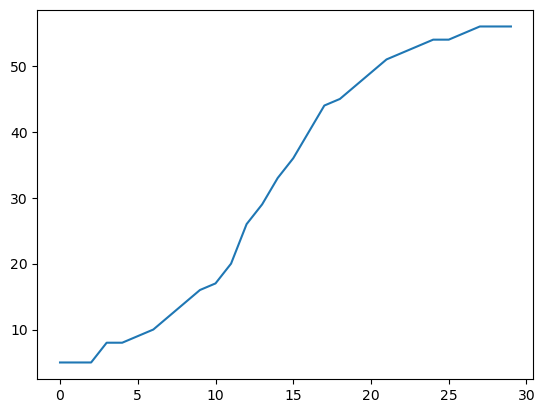

In [12]:
plt.plot(n_cases)

# 3. The Runner class

The Runner class provides functionality to define and run the model multiple times in a convenient way.
All the configuration is read from a config file.
This is the recommended way to run TorchJune.
The config file is self contained and all the configurable options are defined there. The `data_path` is a pickle file with the world data.

In [13]:
runner = Runner.from_file(june_config_path)

In [14]:
results = runner()

AttributeError: 'NodeStorage' object has no attribute 'symptoms'

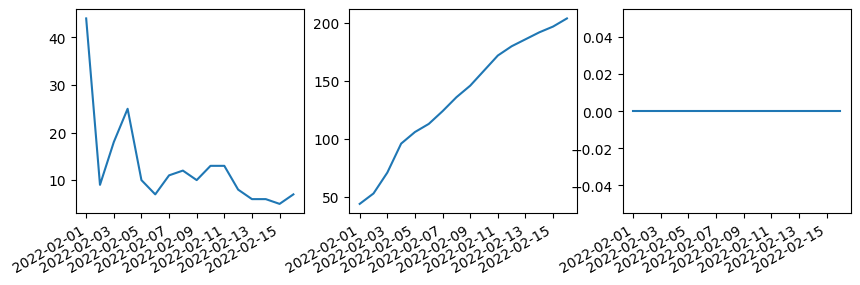

In [15]:
fig, ax = plt.subplots(1,3, figsize=(10, 3))
ax[0].plot(results["dates"], results["daily_cases_per_timestep"].cpu().numpy())
ax[1].plot(results["dates"], results["cases_per_timestep"].cpu().numpy())
ax[2].plot(results["dates"], results["deaths_per_timestep"].cpu().numpy())

fig.autofmt_xdate()